# Time Series Classification Hello World

My first attempt to perform feature engineering on some time series and to build and evaluate a classifier based on these features. Want to compute features manually to understand how this works before using a package like [tsfresh](https://tsfresh.readthedocs.io/en/latest/#). 

Have used a number of resources:

In [17]:
import xgboost
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from matplotlib import pyplot as plt

In [19]:
print(f"xgboost: {xgboost.__version__}")
print(f"pandas: {pd.__version__}")
print(f"statsmodels: {sm.__version__}")
print(f"numpy: {np.__version__}")

xgboost: 1.2.0
pandas: 0.25.3
statsmodels: 0.10.1
numpy: 1.18.1


## Data

Let's start with a univariate time series data set of the daily minimum temperatures measured in degrees Celsius from 1981-01-01 until 1990-12-31 ($3,650$ measurements in total). We want to learn to predict the minimum temperature on a day.

In [3]:
data = pd.read_csv("data/daily-min-temperatures.csv", header=0, index_col=0, parse_dates=True)

In [4]:
data.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [5]:
print(f"Number of measurements: {len(data)}")
print(f"Earliest date: {data.index[0]}")
print(f"Latest date: {data.index[-1]}")

Number of measurements: 3650
Earliest date: 1981-01-01 00:00:00
Latest date: 1990-12-31 00:00:00


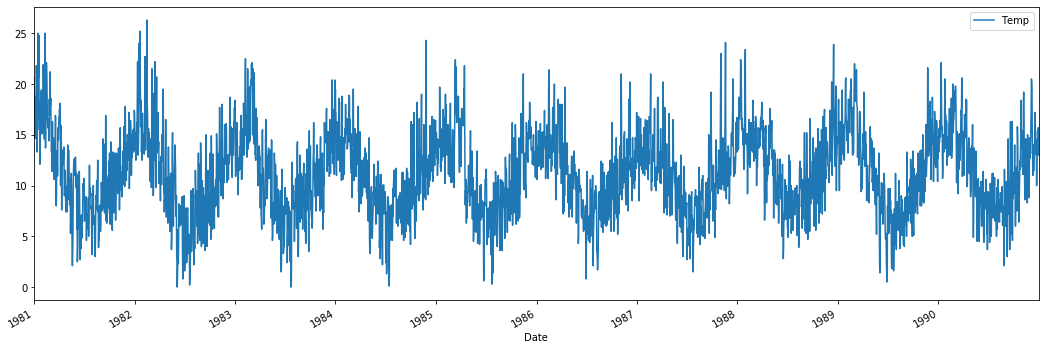

In [21]:
data.plot(figsize=(18, 6))

Can see annual seasonal pattern. Not sure if a trend is visually discernible.

## Date-time based features

One way to create features would be to decompose the dates into date-time based features.

In [6]:
df_features_1 = pd.DataFrame()
df_features_1["Month"] = [data.index[i].month for i in range(len(data.index))]
df_features_1["Day"] = [data.index[i].day for i in range(len(data.index))]
df_features_1["Temp"] = [data.values[i][0] for i in range(len(data))]

In [7]:
df_features_1.sample(5)

,Month,Day,Temp
2701,5,26,12.6
1937,4,23,11.6
2936,1,17,16.6
762,2,2,17.3
2058,8,22,9.7


To predict the temperate based on the month and day is probably not an effective approach. Other date-time based features might perform better for the problem at hand. For example, time of day or season.

## Lag features

Another way to create features is to use lag to try and predict the value at $t + 1$ based on the value(s) at previous points in time.

In [8]:
data_shifted_1 = pd.concat([data["Temp"].shift(1), data["Temp"]], axis=1)
data_shifted_1.columns = ["t-1", "t+1"]
data_shifted_1.head()

,t-1,t+1
Date,,
1981-01-01,NaN,20.7
1981-01-02,20.7,17.9
1981-01-03,17.9,18.8
1981-01-04,18.8,14.6
1981-01-05,14.6,15.8


 The features obtained in this way are called `lag features` and the method to obtain them is called the `sliding window method` (i.e. with a window size of one). We can increase the size of the sliding window as shown below.

In [9]:
data_shifted_3 = pd.concat([data["Temp"].shift(3), data["Temp"].shift(2), data["Temp"].shift(1), data["Temp"]], axis=1)
data_shifted_3.columns = ["t-3", "t-2", "t-1", "t+1"] 
data_shifted_3.head()

,t-3,t-2,t-1,t+1
Date,,,,
1981-01-01,NaN,NaN,NaN,20.7
1981-01-02,NaN,NaN,20.7,17.9
1981-01-03,NaN,20.7,17.9,18.8
1981-01-04,20.7,17.9,18.8,14.6
1981-01-05,17.9,18.8,14.6,15.8


We would nedd to discard the first three rows when training a classifier as they contain incomplete data (`NaN`).

How do you pick the window size? Ideally, your window includes all previous data points whose value helps you predict the current value. If there is a weekly correlation, then having the value from last Monday might help you predict the value for next Monday.

We can measure the correlation between a time series and its lagged values using the auto-correlation function (ACF) or the partial auto-correlation function (PACF).

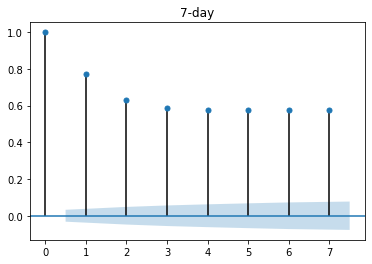

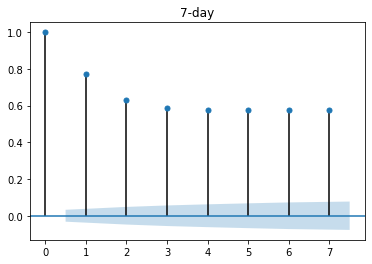

In [10]:
plot_acf(data["Temp"], alpha=.05, lags=7, title="7-day")

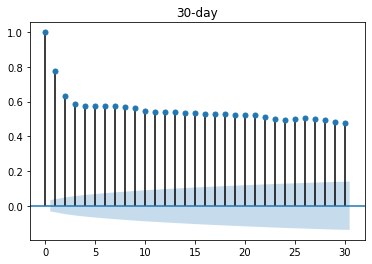

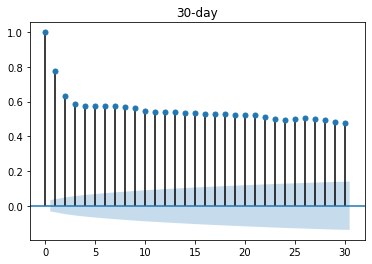

In [11]:
plot_acf(data["Temp"], alpha=.05, lags=30, title="30-day")

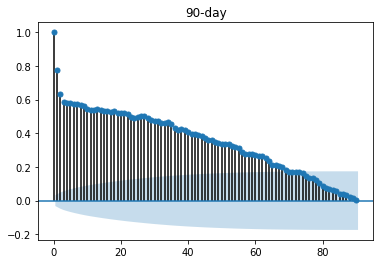

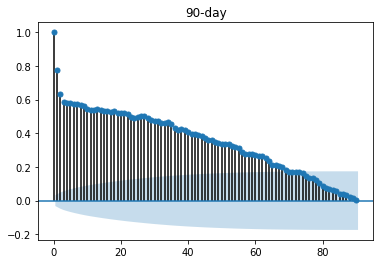

In [12]:
plot_acf(data["Temp"], alpha=.05, lags=90, title="90-day")

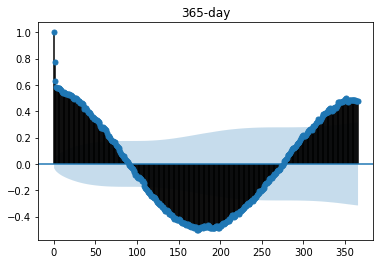

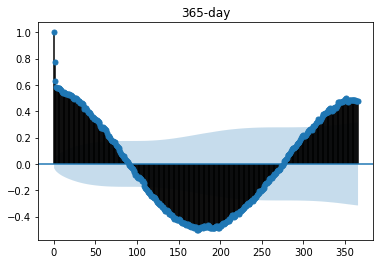

In [13]:
plot_acf(data["Temp"], alpha=.05, lags=365, title="365-day")

We observe almost no decay in auto-correlation for data points with a lag of 7 measurements, a small decay as we get closer to 30 days and much more significant delay beyond that. My interpretation is that the minimum temperatures in a given week tend to stay close to each other, so predicting tomorrow's temperature based on the last few days makes sense. Similarly, but maybe less so for measurements over the past 30 days. As the lag increases beyond one month of measurements, this relationship becomes weaker (as we go back more days). Plotting the auto-correlation coefficient across 365 lags seems to confirm this interpretation as the coefficient goes to zero, around 90 days, has a minimum around 180 days and then approaches a maximum again just as we approach one year out. 

**Not sure my interpretation is correct. Should follow up on this.**

## Rolling window statistics

Another approach to create features from a time series is to summarize data points in a sliding window. The `rolling()` function in Pandas allows us to collect the data points for the specified window and perform computations on these data points. First, a simple example where we use a lag of one to get the hang of things.

In [14]:
# the shift is 1
data_shifted_1 = pd.concat([data["Temp"].shift(1), data["Temp"]], axis=1)
data_shifted_1.columns = ["t-1", "t+1"]
data_shifted_1.head()

,t-1,t+1
Date,,
1981-01-01,NaN,20.7
1981-01-02,20.7,17.9
1981-01-03,17.9,18.8
1981-01-04,18.8,14.6
1981-01-05,14.6,15.8


In [15]:
# the rolling window contains the previous and current data point
window = data_shifted_1.rolling(window=2)
means = window.mean()
stats = pd.concat([data_shifted_1, means["t+1"]], axis=1)
stats.columns = ["t-1", "t+1", "mean(t-2, t+1)"]
stats.head()

,t-1,t+1,"mean(t-2, t+1)"
Date,,,
1981-01-01,NaN,20.7,NaN
1981-01-02,20.7,17.9,19.30
1981-01-03,17.9,18.8,18.35
1981-01-04,18.8,14.6,16.70
1981-01-05,14.6,15.8,15.20


The first `NaN` is due to the shift by one as before. The second `NaN` is due to trying to compute the mean of the first numeric value and `NaN`.

In [17]:
def computeLaggedStats(data, value_name, shifts, drop_nan=True):
    """
    Create as many lagged values as indicated by the shifts parameter on the values in the colum indicated by value_name in the data data frame. Can drop     NaN values (by default).
    """
    column_values = list()
    column_names = list()

    for i in range(shifts, 0, -1):
        column_names.append(f"t-{i}")
        column_values.append(data[value_name].shift(i))
    
    column_names.append("t+1")
    column_values.append(data[value_name])
    aggregate_df = pd.concat(column_values, axis=1)
    aggregate_df.columns = [column_names]
    if drop_nan:
        aggregate_df.dropna(inplace=True)
    return aggregate_df

In [18]:
shifted = computeLaggedStats(data, "Temp", 3, drop_nan=False)
shifted.head()

,t-3,t-2,t-1,t+1
Date,,,,
1981-01-01,NaN,NaN,NaN,20.7
1981-01-02,NaN,NaN,20.7,17.9
1981-01-03,NaN,20.7,17.9,18.8
1981-01-04,20.7,17.9,18.8,14.6
1981-01-05,17.9,18.8,14.6,15.8


In [21]:
# Computing a rolling window over the past three values, such that mean is the mean of t-3, t-2, t-1.
# We have 4 columns we can use as features (theoretically) and t+1 as the label to predict.
shifted = computeLaggedStats(data, "Temp", 3, drop_nan=False)
shifted_past_values = shifted[["t-3", "t-2", "t-1"]]
window = shifted_past_values.rolling(window=3)
means = window.mean()
means.rename(columns={"t-1": "mean"}, inplace=True)
shifted = pd.concat([shifted, means.iloc[:, 2]], axis=1)
shifted.head(7)

,t-3,t-2,t-1,t+1,mean
Date,,,,,
1981-01-01,NaN,NaN,NaN,20.7,NaN
1981-01-02,NaN,NaN,20.7,17.9,NaN
1981-01-03,NaN,20.7,17.9,18.8,NaN
1981-01-04,20.7,17.9,18.8,14.6,19.133333
1981-01-05,17.9,18.8,14.6,15.8,17.100000
1981-01-06,18.8,14.6,15.8,15.8,16.400000
1981-01-07,14.6,15.8,15.8,15.8,15.400000


We could use the same approach to compute other statistics such as the minimum, the maximum or some percentile for each time window (i.e. per row of lagged values).

Another option for computing windowed statistics is to use an expanding window that collects all previous data points at each time step.

In [24]:
expanding_window = shifted_past_values.expanding()
expanding_means = expanding_window.mean()
expanding_means.head(10)

,t-3,t-2,t-1
Date,,,
1981-01-01,NaN,NaN,NaN
1981-01-02,NaN,NaN,20.700000
1981-01-03,NaN,20.700000,19.300000
1981-01-04,20.700000,19.300000,19.133333
1981-01-05,19.300000,19.133333,18.000000
1981-01-06,19.133333,18.000000,17.560000
1981-01-07,18.000000,17.560000,17.266667
1981-01-08,17.560000,17.266667,17.057143
1981-01-09,17.266667,17.057143,17.100000


## Evaluating a classifier on time series data

The general recipe is quite simple:

1. Convert the univariate time series into a supervised problem. Each sample contains one or more features in the form of lagged values and/or statistics over lagged values and a label, which consists of the corresponding value at time $t + 1$.
2. Train and test a classifier on this data.
3. Validate classifier on held out test data set.

Avoid polluting any of these steps by making sure that you do not use future data (i.e. no k-fold cross-validation that jumps back and forth across time stamps).

For time series data, we must split the data into train and test data sets in a way that respects the temporal order of the data. There are three ways to backtest your classifier on time series data: train-test split that respects the temporal order, multiple train-test splits that respect temporal order, walk-forward validation.

### Train-Test Split

A simple train-test split is prepared by picking a split point in the ordered list of observations and creating a training data set from observations before that split point and a test data set as obersvations after that split point. Working through an example below.

In [4]:
sun_spots = pd.read_csv("data/monthly-sunspots.csv", header=0, index_col=0)
sun_spots.head(7)

,Sunspots
Month,
1749-01,58.0
1749-02,62.6
1749-03,70.0
1749-04,55.7
1749-05,85.0
1749-06,83.5
1749-07,94.8


Observations: 2820
Training samples: 1973
Test samples: 847


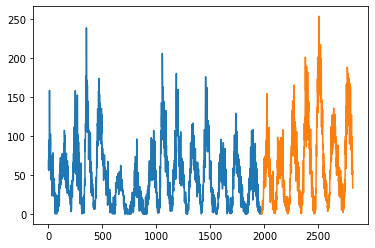

In [25]:
X = sun_spots.values
# X[0:7]
train_size = int(len(X) * 0.70)
train, test = X[0:train_size], X[train_size:len(X)]
print(f"Observations: {len(X)}")
print(f"Training samples: {len(train)}")
print(f"Test samples: {len(test)}")
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])

### Multiple Train-Test Splits

An alternative way is to split the data into a training and test data set multiple times. You can use `TimeSeriesSplit` in scikit-learn to faciliate this. You specify the number of splits and `TimeSeriesSplit` returns the corresponding split indices. The number of observations in each data set per split iteration are computed according to this equation:

$\textit{training size} = i \times \frac{|samples|}{(|splits| + 1)} + |samples| \mod (|splits| + 1)$

and 

$\textit{test size} = \frac{|samples|}{|splits| + 1}$

The size of the test set stays the same for each split, which makes it easier to compare the performance metrics resulting from each experiment.

For example, with 100 samples and two splits, we get a trainining set size of 33 and a test size of 33 on the first split iteration. That is, the first 33 records are used for training and the next 33 records are used for testing. On the second iteration, the training set size is 66 and the test set size is 33. Meaning, the first 67 observations are used for training and the reamining 33 records are used for testing.

## Putting it all together - Training a simple classifier to forecast

Next:

* Learn how to backtest ml models for time series forecasting [here](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
* Build a simple one-step forecaster using XGBoost [eg](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/)
* Start another notebook where you try to figure out how to train a classifier on a labeled temporal data set.
* Maybe try to play with timeseries classification on multivariate data.
* Maybe try to get features computed by a library and see how that works.
* Look into clustering of time series next.

* [ ] **TODO** Split notebook into exploratory one on converting time series into data set suitable for supverised forecasting (time series feature extraction) and other ones training classifiers.
* [ ] **TODO** Write a function to shift and compute rolling window statistics using a shifts parameter, maybe in a loop that decrements shift.  
* [ ] **TODO** Figure out how to convert the time series to a labeled data set that you can train a supervised classifier for forecasting on.
* [ ] **TODO** Experiment with different features trying to build an XGBoost classifier.
* [ ] **TODO** Figure out how to handle multivariate time series data for forecasting using a supervised classifier.
* [ ] **TODO** Try your hand not at forecasting, but at a problem with labels (based on multivariate time series) to experience how time series feature extraction (and classification) works in that case.

Also want to add a lag value from same day in the previous year.